In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

In [2]:
df = pd.read_csv('./spam_or_not_spam.csv')
df.head()

,email,label
0,mike bostock said received from trackingNUMBE...,0
1,no i was just a little confused because i m r...,0
2,this is just an semi educated guess if i m wro...,0
3,jm URL justin mason writes except for NUMBER t...,0
4,i just picked up razor sdk NUMBER NUMBER and N...,0


In [3]:
df.shape

(1500, 2)

In [4]:
df['label'].value_counts()

0    1000
1     500
Name: label, dtype: int64

In [5]:
# Check for null values
df.isna().sum()  

email    1
label    0
dtype: int64

In [6]:
# Drop the row with the null value 
df.dropna(inplace=True) 

In [7]:
# Split our dataset into training and test 
X_train, X_test, y_train, y_test = train_test_split(df['email'].to_numpy(), df['label'].to_numpy(), test_size=0.25, random_state=42)

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1124, 1124, 375, 375)

### Converting text into numbers

In [9]:
# Find the average number of words in the training emails
round(sum([len(i.split()) for i in X_train])/len(X_train))

197

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000 # max numbers of worlds to have in our vocabulary
max_length = 200 # max length of sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    output_mode='int', 
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to text set
text_vectorizer.adapt(X_train)

### Create an Embedding Layer

In [12]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer='uniform',
                             input_length=max_length)

In [13]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  # Calculate model precision, recall and f1 score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  print(f'F1 score: {model_f1*100:.2f}%')
  print(f'Recall: {model_recall*100:.2f}%')
  print(f'Precision: {model_precision*100:.2f}%')

## Dense model

In [26]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
x = layers.Dense(10, activation='relu')(x) # Dense layer
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer, want binary outputs so we sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name='dense_model') # construct the model

# Compile model
model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [28]:
model_1.summary()

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 200)               0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          1280000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,281,301
Trainable params: 1,281,301
Non-trainable params: 0
_____________________________________________

In [17]:
# Fit the model
model = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
36/36 [==============================] - 1s 15ms/step - loss: 0.6607 - accuracy: 0.6423 - val_loss: 0.6221 - val_accuracy: 0.6507
Epoch 2/10
36/36 [==============================] - 0s 11ms/step - loss: 0.5709 - accuracy: 0.7206 - val_loss: 0.5387 - val_accuracy: 0.7307
Epoch 3/10
36/36 [==============================] - 0s 11ms/step - loss: 0.4839 - accuracy: 0.7989 - val_loss: 0.4554 - val_accuracy: 0.8240
Epoch 4/10
36/36 [==============================] - 0s 11ms/step - loss: 0.3835 - accuracy: 0.8754 - val_loss: 0.3563 - val_accuracy: 0.8507
Epoch 5/10
36/36 [==============================] - 0s 10ms/step - loss: 0.2777 - accuracy: 0.9164 - val_loss: 0.2627 - val_accuracy: 0.9253
Epoch 6/10
36/36 [==============================] - 0s 10ms/step - loss: 0.1975 - accuracy: 0.9466 - val_loss: 0.1999 - val_accuracy: 0.9413
Epoch 7/10
36/36 [==============================] - 0s 11ms/step - loss: 0.1452 - accuracy: 0.9600 - val_loss: 0.1592 - val_accuracy: 0.9440
Epoch 8/10
36

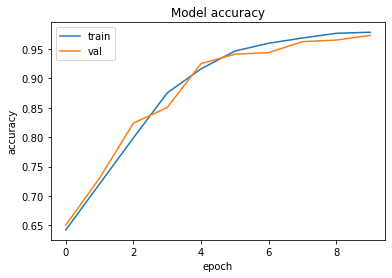

In [18]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

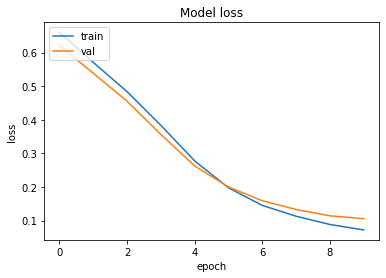

In [19]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
model_1_preds = model_1.predict(X_test)
model_1_preds[:10]

array([[9.89732385e-01],
       [9.98466372e-01],
       [9.10350978e-02],
       [1.00643486e-01],
       [1.06425136e-01],
       [1.14789426e-01],
       [7.71797478e-01],
       [4.20401990e-02],
       [8.91339064e-01],
       [9.93788242e-04]], dtype=float32)

In [21]:
model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0.], dtype=float32)>

In [22]:
model_1_results = calculate_results(y_test, model_1_preds)

F1 score: 97.31%
Recall: 97.33%
Precision: 97.44%
